# MCMC with X_HI  Likelihoods

# 21BHFAST

### Parte 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from py21cmmc import analyse, mcmc
import py21cmmc as p21mc
import logging
from scipy.interpolate import InterpolatedUnivariateSpline
from py21cmmc.likelihood import LikelihoodBase


In [2]:
import logging
print("Version of py21cmmc: ", p21mc.__version__)

Version of py21cmmc:  1.0.0dev3


In [3]:
pip show 21cmFAST

Name: 21cmFAST
Version: 0.1.dev57+gbf67ddc
Summary: A semi-numerical cosmological simulation code for the 21cm signal
Home-page: https://github.com/21cmFAST/21cmFAST
Author: The 21cmFAST coredev team
Author-email: 21cmfast.coredev@gmail.com
License: MIT license
Location: /home/ogarcia/miniconda3/envs/BH_V1/lib/python3.10/site-packages
Requires: astropy, attrs, bidict, cached_property, cffi, click, cosmotile, h5py, matplotlib, numpy, pyyaml, scipy
Required-by: 21cmMC
Note: you may need to restart the kernel to use updated packages.


# ------------------------------------------------------------------------------------------

# Prueva 1
## Parte 2

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from py21cmmc import analyse
from py21cmmc import mcmc
import py21cmmc as p21mc
from py21cmmc.likelihood import LikelihoodBase  # Necesario para herencia
import logging

logger = logging.getLogger(__name__)

%load_ext autoreload
%autoreload 2

print("Version of py21cmmc: ", p21mc.__version__)

#   LikelihoodNeutralFraction --------------------------------------------------------------------------------
class LikelihoodNeutralFraction(LikelihoodBase):
    required_cores = (
        (
            p21mc.core.CoreLightConeModule,
            p21mc.core.CoreCoevalModule,
            p21mc.core.CoreCMB,
            p21mc.core.Core21cmEMU,
        ),
    )
    threshold = 0.06

    def __init__(self, redshift=5.9, xHI=0.06, xHI_sigma=0.05):
        super().__init__()
        self.redshift = np.atleast_1d(redshift)
        self.xHI = np.atleast_1d(xHI)
        self.xHI_sigma = np.atleast_1d(xHI_sigma)
        self._use_coeval = True
        self._require_spline = False
        self._use_tanh = False

    def setup(self):
        if not any(isinstance(m, (p21mc.core.CoreLightConeModule, p21mc.core.CoreCoevalModule, 
                                 p21mc.core.CoreCMB, p21mc.core.Core21cmEMU)) 
                  for m in self._cores):
            raise ValueError("LikelihoodNeutralFraction necesita un módulo compatible.")
        if any(isinstance(m, p21mc.core.CoreLightConeModule) for m in self._cores):
            self._use_coeval = False
            self._require_spline = True
        elif any(isinstance(m, (p21mc.core.CoreCMB, p21mc.core.Core21cmEMU)) for m in self._cores):
            self._use_tanh = True
            self._use_coeval = False
            self._require_spline = True
        else:
            self.redshifts = list(set(sum((x.redshift for x in self.coeval_modules), [])))
            for z in self.redshift:
                if z not in self.redshifts and len(self.redshifts) < 3:
                    raise ValueError("Necesita >=3 redshifts o el redshift deseado.")
                elif z not in self.redshifts:
                    self._require_spline = True

    def reduce_data(self, ctx):
        err = 0
        if self._use_coeval:
            xHI = np.array([np.mean(x) for x in ctx.get("xHI")])
            redshifts = self.redshifts
        else:
            if self._use_tanh:
                xHI = ctx.get("xHI")
                redshifts = ctx.get("zs") or ctx.get("redshifts")
                err = ctx.get("xHI_err", 0)
            else:
                xHI = ctx.get("lightcone").global_xH
                redshifts = ctx.get("lightcone").node_redshifts
        print("Raw xHI shape:", xHI.shape)
        print("Raw redshifts:", redshifts)
        # Corregir el ordenamiento
        if xHI.ndim == 1:
            sort_idx = np.argsort(redshifts)
            redshifts = np.array(redshifts)[sort_idx]
            xHI = xHI[sort_idx]
        return {"xHI": xHI, "redshifts": redshifts, "err": err}

    def computeLikelihood(self, model):
        xHI = model["xHI"]  # 1D para un solo walker
        redshifts = model["redshifts"]
        lnprob = 0

        print("Shape de model['xHI']:", xHI.shape)
        print("model['redshifts']:", redshifts)
        print("Número de redshifts:", len(redshifts))

        if self._require_spline and len(redshifts) > 1:
            try:
                model_spline = InterpolatedUnivariateSpline(redshifts, xHI, k=1)
            except ValueError as e:
                print(f"Error en spline: {e}")
                return -np.inf
        else:
            model_spline = None
            if len(redshifts) <= 1:
                print("Advertencia: Solo 1 redshift, no se usa spline.")

        for z, data, sigma in zip(self.redshift, self.xHI, self.xHI_sigma):
            sigma_t = sigma if np.sum(model["err"]) == 0 or not model_spline else np.sqrt(sigma**2 + model["err"])
            if z in redshifts:
                idx = np.where(redshifts == z)[0][0]
                lnprob += self.lnprob(xHI[idx], data, sigma_t)
            elif model_spline:
                lnprob += self.lnprob(model_spline(z), data, sigma_t)
            else:
                lnprob = -np.inf
                break

        logger.debug(f"Neutral fraction Likelihood: {lnprob}")
        return lnprob  

    def lnprob(self, model, data, sigma):
        model = np.clip(model, 0, 1)
        if model > self.threshold:
            return -0.5 * ((data - model) / sigma) ** 2
        return 0
# -------------------------------------------------------------------------------------------------------------------
#  CoreLightConeModule
core = p21mc.CoreLightConeModule(
    redshift=5.5,
    max_redshift=7.0,
    user_params=dict(
        HII_DIM=50,
        BOX_LEN=125.0,
        N_THREADS= 8
    ),
    z_step_factor=1.04,
    z_heat_max=18.0,
    regenerate=False
)

# likelihood planck
likelihood = LikelihoodNeutralFraction(
    redshift=5.9,
    xHI=0.06,
    xHI_sigma=0.05
)

# Verificar qué clase se usa
print("Likelihood class:", likelihood.__class__.__module__ + "." + likelihood.__class__.__name__)

#  MCMC
model_name = "LightconeNeutralFractionTest"

chain = mcmc.run_mcmc(
    core, likelihood,
    datadir='data',
    model_name=model_name,
    params=dict(
        ALPHA = [0.03, 0.01, 0.3, 0.5],
        BETA = [0.7, 0.2, 2, 0.5],
        L_X_MINI = [40.5, 35.0, 45.0, 3.0],
        F_ESC7_MIN = [-2.22, -3, 0, 0.5],
        F_STAR7_MINI = [-1.75, -3, 0, 0.5], 
        HII_EFF_FACTOR=[30.0, 10.0, 50.0, 3.0],
        ION_Tvir_MIN=[4.7, 4, 6, 0.1],
    ),
    walkersRatio=8,
    burninIterations=0,
    sampleIterations=30,
    threadCount=6,
    continue_sampling=False,
    log_level_stream=logging.DEBUG
)

# Análisis
#samples = chain.samples
#analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True)
#analyse.corner_plot(samples)

Version of py21cmmc:  1.0.0dev3
Likelihood class: __main__.LikelihoodNeutralFraction


/home/ogarcia/miniconda3/envs/BH_V1/lib/python3.10/site-packages/py21cmfast/inputs.py:519: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
2025-03-05 18:19:08,645 INFO:Using CosmoHammer 0.6.1
2025-03-05 18:19:08,647 INFO:Using emcee 2.2.1
2025-03-05 18:19:08,675 INFO:all burnin iterations already completed
2025-03-05 18:19:08,679 INFO:Sampler: <class 'py21cmmc.cosmoHammer.CosmoHammerSampler'>
configuration: 
  Params: [ 3.00e-02  7.00e-01  4.05e+01 -2.22e+00 -1.75e+00  3.00e+01  4.70e+00]
  Burnin iterations: 0
  Samples iterations: 30
  Walkers ratio: 8
  Reusing burn in: True
  init pos generator: SampleBallPositionGenerator
  stop criteria: IterationStopCriteriaStrategy
  storage util: <py21cmmc.cosmoHamme

Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.76259975 5.89785161 6.03580851 6.17652455
 6.3200549  6.46645586 6.61578484 6.76810039 6.92346225 7.08193134]
Número de redshifts: 12
Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.76259975 5.89785161 6.03580851 6.17652455
 6.3200549  6.46645586 6.61578484 6.76810039 6.92346225 7.08193134]
Número de redshifts: 12
Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.

2025-03-05 18:27:31,013 INFO:Iteration finished:10


Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.76259975 5.89785161 6.03580851 6.17652455
 6.3200549  6.46645586 6.61578484 6.76810039 6.92346225 7.08193134]
Número de redshifts: 12
Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.76259975 5.89785161 6.03580851 6.17652455
 6.3200549  6.46645586 6.61578484 6.76810039 6.92346225 7.08193134]
Número de redshifts: 12
Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.

2025-03-05 18:33:58,399 INFO:Iteration finished:20


Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.76259975 5.89785161 6.03580851 6.17652455
 6.3200549  6.46645586 6.61578484 6.76810039 6.92346225 7.08193134]
Número de redshifts: 12
Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.76259975 5.89785161 6.03580851 6.17652455
 6.3200549  6.46645586 6.61578484 6.76810039 6.92346225 7.08193134]
Número de redshifts: 12
Raw xHI shape: (12,)
Raw redshifts: [7.08193134 6.92346225 6.76810039 6.61578484 6.46645586 6.3200549
 6.17652455 6.03580851 5.89785161 5.76259975 5.62999988 5.5       ]
Shape de model['xHI']: (12,)
model['redshifts']: [5.5        5.62999988 5.

2025-03-05 18:40:33,529 INFO:Iteration finished:30
2025-03-05 18:40:33,530 INFO:sampling done! Took: 1284.8227s
2025-03-05 18:40:33,531 INFO:Mean acceptance fraction:0.3


In [5]:
samples = chain.samples

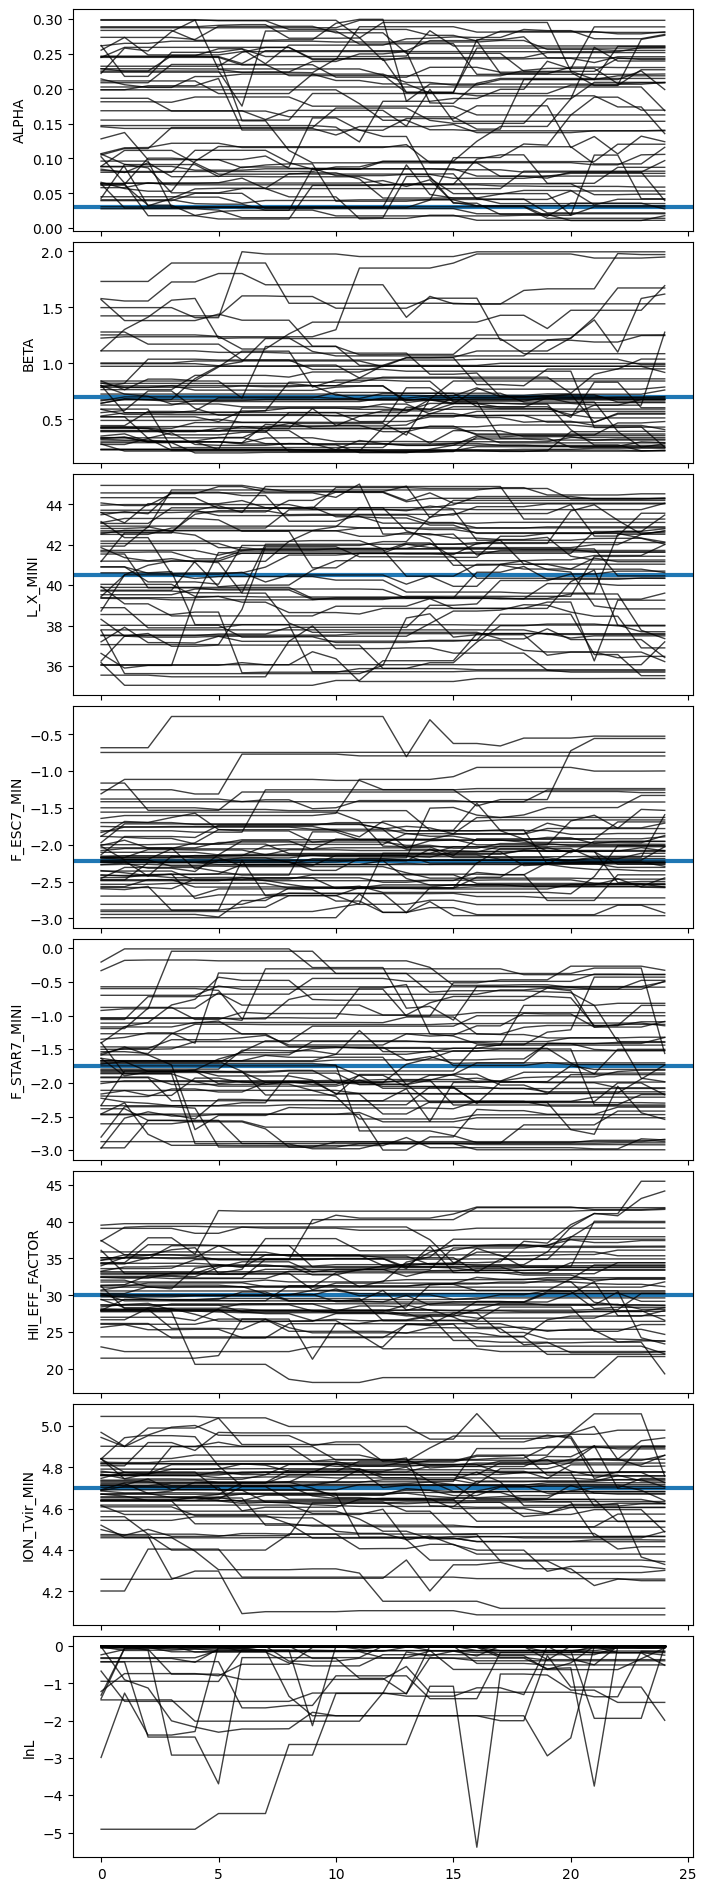

In [6]:
#analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True)
analyse.trace_plot(samples, include_lnl=True, start_iter=5, thin=1, colored=False, show_guess=True);
plt.savefig('Trace Plot_Likelihood_XHI(21BHFAST).jpg', dpi=300, bbox_inches='tight')

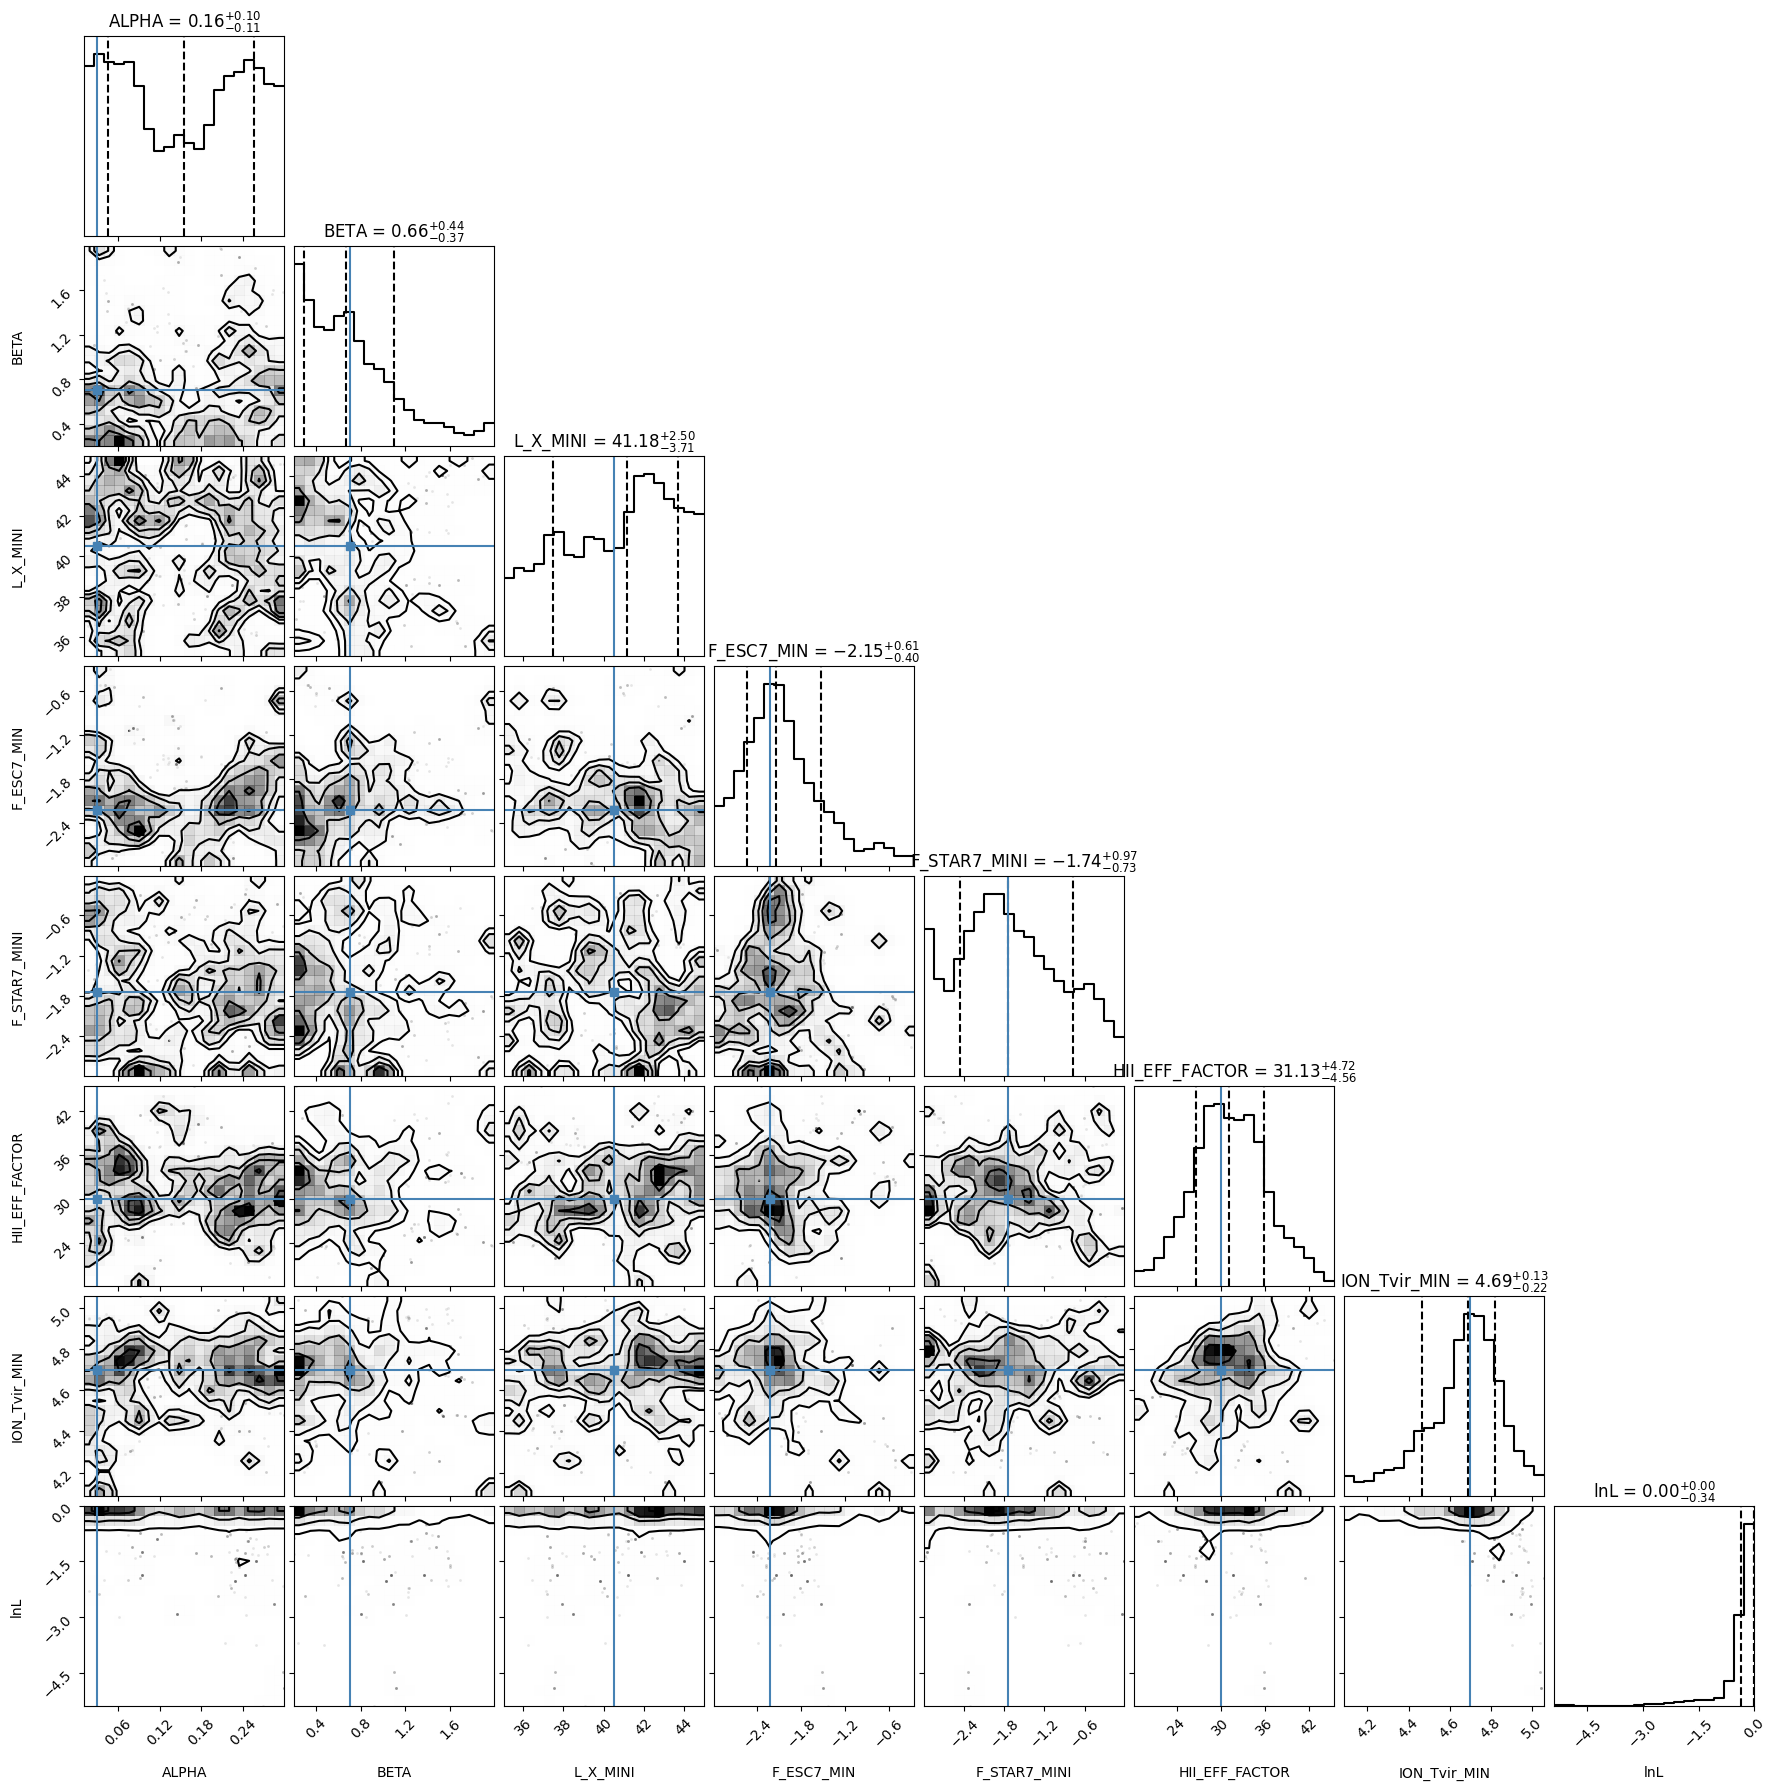

In [7]:
#analyse.corner_plot(samples)

analyse.corner_plot(samples, start_iter=5);
plt.savefig('corner Plot_Likelihood_XHI(21BHFAST).jpg', dpi=300, bbox_inches='tight')